In [1]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np
import pandas as pd

from plasticc.dataset import Dataset

/home/kk385830/miniconda3/envs/plasticc/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
ds = Dataset('../data/sets/tsfresh-sample/', y_colname='target')

In [3]:
X, y = ds.train

### Eliminate null values

In [4]:
len(X.columns)

1886

In [5]:
na_cols = [col for col in X.columns if X[col].isna().any()]
len(na_cols)

1

In [6]:
{
    na_col: X[na_col].isna().sum() for na_col in na_cols
}

{'distmod': 2325}

In [7]:
X.dropna(axis=1, inplace=True)

In [8]:
assert(X.notna().all().all())

In [9]:
X.drop(columns='object_id_meta', inplace=True)

### Eliminate inifinte values

In [10]:
X.replace([np.inf, -np.inf], np.nan, inplace=True)

In [11]:
na_cols = [col for col in X.columns if X[col].isna().any()]
len(na_cols)

2

In [12]:
na_cols

['0__sample_entropy', '1__sample_entropy']

In [13]:
X.drop(columns=na_cols, inplace=True)

In [14]:
X.shape

(7848, 1882)

In [15]:
y.shape

(7848,)

In [17]:
model1 = XGBClassifier(nthread=16)
model2 = RandomForestClassifier()

In [18]:
model1.fit(X.values.astype(np.float32), y.values.astype(np.int), verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=16, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [19]:
model2.fit(X.values.astype(np.float32), y.values.astype(np.int))

/home/kk385830/miniconda3/envs/plasticc/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Calculate feature imporatnce

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import describe
import tsfresh
import pandas as pd

In [56]:
def to_tsfresh_format(feature_set: set, train_X: pd.DataFrame) -> dict:
    """ Converts a set of features names into tsfresh-acceptable settings dict. """
    df_selected = train_X[list(feature_set)]
    return tsfresh.feature_extraction.settings.from_columns(df_selected)

def select_features_from_trained_model(model, train_X: pd.DataFrame, meta_columns: set, verbose=True) -> set:
    """
    Extracts a set of relevant features from trained model.
    Parameters:
    - train_X should be the X used to train the model
    - meta_columns should contain column names that will be excluded from the tsfresh selection (columns from metadata, not the time series)
    """
    print(describe(model.feature_importances_))
    features = pd.Series(model.feature_importances_, index=train_X.columns)
    print("Most relevant features for the model:", features.sort_values().tail(10))
    # calculating how much data is lost based on minimal importance level
    N_THRESHOLDS = 1000
    select_crit = np.zeros(N_THRESHOLDS)
    select_min = np.zeros(N_THRESHOLDS)
    for i, q in enumerate(np.linspace(features.min(), features.max(), N_THRESHOLDS, endpoint=False)):
        selected = features[features > q]
        select_crit[i] = selected.min() * len(selected) / len(features)
        select_min[i] = selected.min()
    # choosing minimum importance level that maximizes (selected feature count * minimal selected feature importance)
    min_importance = select_min[np.argmax(select_crit)]
    selected_features = set(features[features > min_importance].index) - meta_columns
    if verbose:
        print(f"Selected minimal importance: {min_importance}", f"Number of selected features: {len(selected_features)}")
        plt.plot(select_crit)
        plt.show()
    return selected_features, features

In [57]:
meta_columns = set(Dataset('../data/sets/base/').train_meta.columns)

DescribeResult(nobs=1882, minmax=(0.0, 0.12440682), mean=0.0005313496, variance=9.079897e-06, skewness=37.110294342041016, kurtosis=1516.7057451720254)
Most relevant features for the model: hostgal_photoz_err                       0.006028
4__fft_aggregated__aggtype_"kurtosis"    0.006284
2__fft_aggregated__aggtype_"kurtosis"    0.006926
4__skewness                              0.007567
1__abs_energy                            0.007695
hostgal_photoz                           0.009234
1__skewness                              0.010773
3__skewness                              0.011286
2__skewness                              0.013595
hostgal_specz                            0.124407
dtype: float32
Selected minimal importance: 0.0006412722868844867 Number of selected features: 373


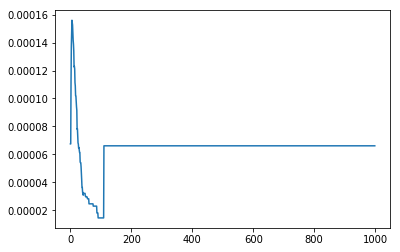

In [58]:
xgb_fset, xgb_feature_importance = select_features_from_trained_model(model1, X, meta_columns)

DescribeResult(nobs=1882, minmax=(0.0, 0.026418196773151166), mean=0.0005313496280552603, variance=1.8073295956759233e-06, skewness=11.573548759054617, kurtosis=188.29432473453332)
Most relevant features for the model: 4__cid_ce__normalize_True                                        0.007975
3__skewness                                                      0.007994
2__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.0    0.008591
3__minimum                                                       0.008901
1__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0    0.009017
3__cid_ce__normalize_True                                        0.010155
3__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.0     0.010191
hostgal_photoz_err                                               0.023315
hostgal_photoz                                                   0.025681
hostgal_specz                                                    0.026418
dtype: float64
Selected minimal importanc

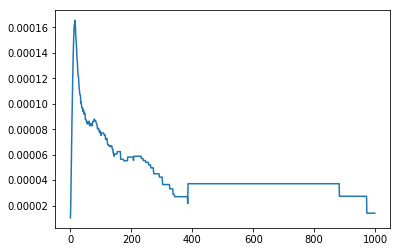

In [59]:
skl_fset, skl_feature_importance = select_features_from_trained_model(model2, X, meta_columns)

In [60]:
important_for_both = xgb_fset & skl_fset

In [61]:
len(important_for_both)

296

In [62]:
common_dict = to_tsfresh_format(important_for_both, X)

In [65]:
type(common_dict)

dict

#### Decrease number of features
There are some inconsistencies when it comes to which features are extracted for which series.
We will limit extracted features to those relevant for most of the 6 series for now.

In [71]:
keyset = set()
for i in range(6):
    keyset |= set(common_dict[str(i)].keys())

In [72]:
len(keyset)

38

In [105]:
feature_counts = dict()
for feature in keyset:
    for i in range(6):
        for key in common_dict[str(i)].keys():
            if feature in key:
                try:
                    feature_counts[feature] += 1
                except KeyError:
                    feature_counts[feature] = 1

In [106]:
feature_counts = pd.Series(feature_counts)

In [108]:
feature_counts.sort_values(ascending=False).mean()

4.605263157894737

In [109]:
final_features = set(feature_counts[feature_counts > 4].index)

In [110]:
final_features

{'abs_energy',
 'agg_autocorrelation',
 'approximate_entropy',
 'autocorrelation',
 'c3',
 'change_quantiles',
 'cid_ce',
 'energy_ratio_by_chunks',
 'fft_aggregated',
 'fft_coefficient',
 'linear_trend',
 'maximum',
 'mean',
 'quantile',
 'ratio_beyond_r_sigma',
 'skewness',
 'time_reversal_asymmetry_statistic'}

### Save feature dict for tsfresh feature generator to use

In [90]:
import pickle

from tsfresh.feature_extraction.settings import ComprehensiveFCParameters

In [92]:
settings = ComprehensiveFCParameters()
comprehensive_keys = set(settings.keys())
for key in comprehensive_keys:
    if key not in final_features:
        del settings[key]

In [93]:
with open('../data/config/tsfresh-settings.pkl', 'wb+') as file:
    pickle.dump(settings, file)